In [1]:
# I - : Importing  the library and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import joblib
from joblib import dump, load
from datetime import datetime
from keras.models import Sequential, Model,load_model
from keras.layers import Dropout,Dense
from keras import Input,layers
from keras.layers import LSTM, GRU,Bidirectional
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.utils import plot_model
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,VotingRegressor,GradientBoostingRegressor
#from sklearn.externals import joblib
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D,MaxPooling1D,LSTM, GRU,Bidirectional,GlobalMaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.optimizers import TFOptimizer
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.utils import plot_model
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,VotingRegressor,GradientBoostingRegressor

Using TensorFlow backend.


In [2]:
# II - : Importing the training set

In [3]:
dataset=pd.read_csv("https://raw.githubusercontent.com/oreilly-mlsec/book-resources/599669c7124dffb65ea7f6e0b7626df32496b1d6/chapter3/datasets/cpu-utilization/cpu-full-b.csv", sep=",")

In [4]:
# III -  split of data Test & Training

# III.1 - : Size the data Test, Training
train_size=int(len(dataset)*.85)
test_size=int(len(dataset)*.15)
x_trainning,x_testing=dataset.iloc[0:train_size],dataset.iloc[(train_size+1):(train_size+test_size)]

In [6]:

# III.3 - : Preparing data for timesteps (lags)

#THE TWO FUNCTIONS WE WILL BE USEFUL FOR THE FOLLOWING

def preparation_data(data,lags):
        x_train = []
        y_train = []
        for i in range(lags,len(data)):
            x_train.append(data[i-lags:i, 0])
            y_train.append(data[i, 0])
        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        return x_train, y_train

def normalisationPreparationDonnee(data,lags):
    data=data['cpu'].values
    sc = MinMaxScaler(feature_range = (0, 1))
    #sc=StandardScaler()
    data1= data.reshape(-1,1)
    data2 = sc.fit_transform(data1)
    def preparation_data():
        x_train = []
        y_train = []
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
        return np.array(x_train), np.array(y_train)
    x_train, y_train = preparation_data()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train


In [7]:
# IV - TRAINING OF DIFFERENTS MODELS

lags=5

x_train, y_train = normalisationPreparationDonnee(x_trainning, lags)
x_test, y_test = normalisationPreparationDonnee(x_testing, lags)


In [8]:

# IV.1 - : Entrainement du modele RNN-LSTM

# IV.1.1 - : Initialising the RNN-LSTM

start=time()
modelLSTM = Sequential()
modelLSTM.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
modelLSTM.add(LSTM(units = 128, return_sequences = True))
modelLSTM.add(LSTM(units = 64, return_sequences = True))
modelLSTM.add(LSTM(units = 32, return_sequences = True))
modelLSTM.add(LSTM(units = 64, return_sequences = True))
modelLSTM.add(LSTM(units = 128, return_sequences = True))
modelLSTM.add(LSTM(units = 100))
modelLSTM.add(Dense(units = 1))
modelLSTM.compile(optimizer = 'adam', loss = 'mse',
              metrics=['accuracy'])
print(modelLSTM.summary())

historylstm=modelLSTM.fit(x_train, y_train, epochs = 500,batch_size = 5,
                  validation_split=0.20,verbose=1)

elapsed=time()-start

print('duree totale est de :',elapsed/60)
# 27 minutes



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            117248    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 64)             24832     
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               9

TypeError: 'InputLayer' object is not iterable

In [ ]:
plot_model(modelLSTM,show_shapes=True, to_file='regressor.png')

plot_model(modelLSTM,to_file='regressor.png')

C:\Users\luc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


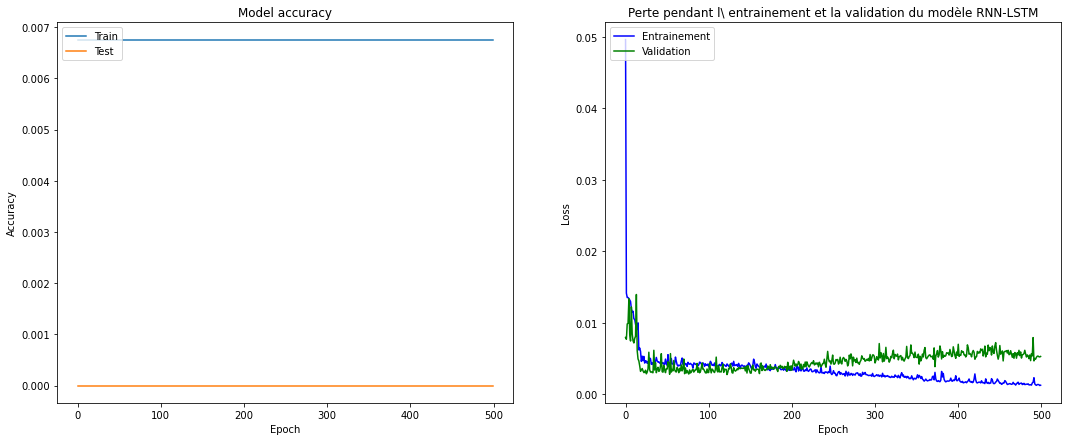

In [12]:
# IV.1.2 - :Plot training & validation accuracy values
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(historylstm.history['accuracy'])
plt.plot(historylstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.subplot(1,2,2)
# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(historylstm.history['loss'],'b',label='Entrainement')
plt.plot(historylstm.history['val_loss'],'green',label='Validation')
plt.title('Perte pendant l\ ''entrainement et la validation du modèle RNN-LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Entrainement', 'Validation'], loc='upper left')


In [14]:
# IV.1.3 - : Saving and importing the model

modelLSTM.save('modelRnnLSTMProj.h5') 

#creates a HDF5 file 'my_model.h5' et model = load_model('modelRnnLSTMProjetSecurite.h5')
# pour le detruire del model  # deletes the existing model
modelLSTM = load_model('modelRnnLSTMProj.h5')

La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9687936583120452
La MAE modèle Erreur données Entrainement est de: 0.026694714004616076 
La MSE modèle Erreur données Entrainement est de: 0.001936182103769523 
RMSE est:0.0440020693123576
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.7713150388457085
La MAE modèle Erreur données test est de: 0.08074357956418976 
La MSE modèle Erreur données test est de: 0.017782150955936788 
RMSE est:0.13334973174302522
Les pertes sur les données enrainement sont: 
loss: 0.19%
accuracy: 0.54%
Les pertes sur les données Test sont: 
loss: 1.78%
accuracy: 4.30%


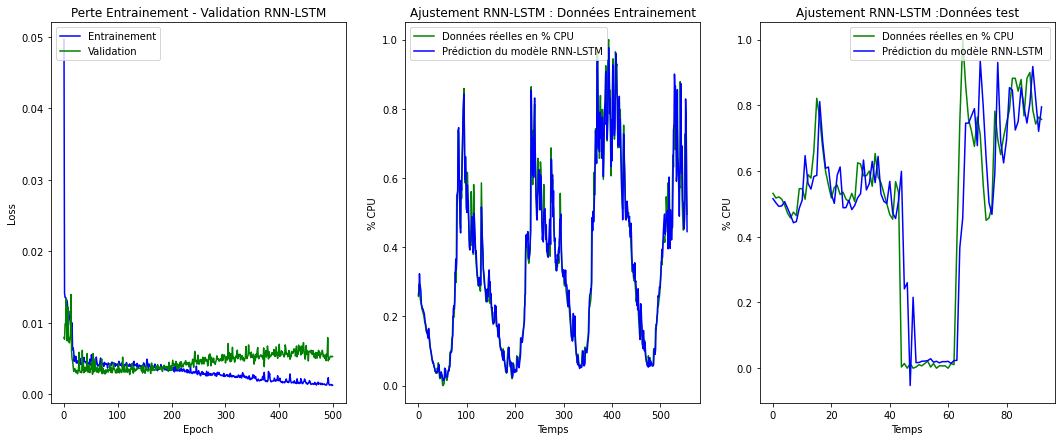

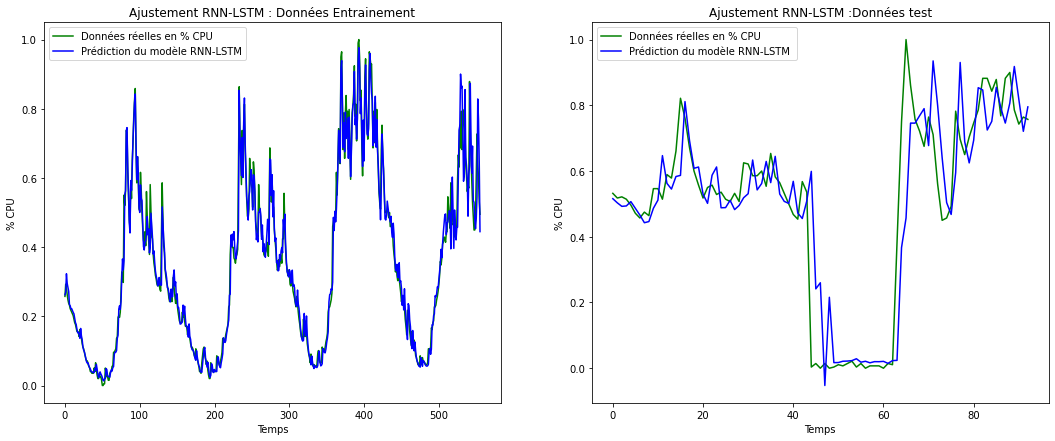

In [15]:
#  IV.1.4 - : Calculating Errors and Viewing Model Fits
# on Training and Test data

def ErreurPrediction(Nommodele,data,prediction ):
    print('La R^2-Squared(r2_score) du modèle {} est : {}'.format(Nommodele,r2_score(data,prediction)))
    print('La MAE modèle {} est de: {} '.format(Nommodele,mean_absolute_error(data,prediction)))
    print('La MSE modèle {} est de: {} '.format(Nommodele,mean_squared_error(data,prediction)))
    print('RMSE est:{}'.format(np.sqrt(mean_squared_error(data,prediction))))
   

def LossAccuracy(nomDonnées,modelLSTM,x_test,y_test):
    score = modelLSTM.evaluate(x_test, y_test,verbose=0)
    erreur=modelLSTM.metrics_names
    print('Les pertes sur les données {} sont: '.format(nomDonnées))
    print("%s: %.2f%%" % (erreur[0], score[0]*100))
    print("%s: %.2f%%" % (erreur[1], score[1]*100))


#  IV.1.5 - : Viewing two-by-two graphs

def Affichage(historylstm,modelLSTM,Nommodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,7))
    plt.subplot(1,3,1)
    plt.plot(historylstm.history['loss'],'b',label='Entrainement')
    plt.plot(historylstm.history['val_loss'],'green',label='Validation')
    plt.title('Perte Entrainement - Validation {}'.format(Nommodele))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Entrainement', 'Validation'], loc='upper left')
    plt.subplot(1,3,2)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(Nommodele))
    plt.title('Ajustement {} : Données Entrainement'.format(Nommodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(Nommodele))
    plt.title('Ajustement {} :Données test'.format(Nommodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    
def Affichage_Model(modelLSTM,NomDumodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(NomDumodele))
    plt.title('Ajustement {} : Données Entrainement'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(NomDumodele))
    plt.title('Ajustement {} :Données test'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    
ErreurPrediction("Erreur données Entrainement",y_train,modelLSTM.predict(x_train))
ErreurPrediction("Erreur données test",y_test,modelLSTM.predict(x_test))

LossAccuracy("enrainement",modelLSTM,x_train,y_train)
LossAccuracy("Test", modelLSTM,x_test,y_test)

Affichage(historylstm,modelLSTM,"RNN-LSTM")

Affichage_Model(modelLSTM,"RNN-LSTM")

In [16]:
#  IV.2 - : Training of the RNN-GRU model  

#  IV.2.1 - : Initialization of the Gru model

start=time()
modelGRU = Sequential()
modelGRU.add(GRU(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
modelGRU.add(GRU(units = 128, return_sequences = True))
modelGRU.add(GRU(units = 64, return_sequences = True))
modelGRU.add(GRU(units = 32, return_sequences = True))
modelGRU.add(GRU(units = 64, return_sequences = True))
modelGRU.add(GRU(units = 128, return_sequences = True))
modelGRU.add(GRU(units = 100))
modelGRU.add(Dense(units = 1))
modelGRU.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])
print(modelGRU.summary())

historygru=modelGRU.fit(x_train, y_train, epochs = 500, batch_size = 5,
                        validation_split=0.20,verbose=1)

elapsed=time()-start

print('duree totale est de :',elapsed/60)
# 21 minutes


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 100)            30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 128)            88320     
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 64)             37248     
_________________________________________________________________
gru_3 (GRU)                  (None, 5, 32)             9408      
_________________________________________________________________
gru_4 (GRU)                  (None, 5, 64)             18816     
_________________________________________________________________
gru_5 (GRU)                  (None, 5, 128)            74496     
_________________________________________________________________
gru_6 (GRU)                  (None, 100)              

In [17]:
#  IV.2.2 - : Enregistrement et importation  du model

modelGRU.save('modelRnnGRUProj.h5') 

#creates a HDF5 file 'my_model.h5' et model = load_model('modelRnnLSTMProjetSecurite.h5')
# pour le detruire del model  # deletes the existing model
modelGRU = load_model('modelRnnGRUProj.h5')

La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9766268835356443
La MAE modèle Erreur données Entrainement est de: 0.019308695448760804 
La MSE modèle Erreur données Entrainement est de: 0.0014501735019159271 
RMSE est:0.038081143652940984
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.7364387274027108
La MAE modèle Erreur données test est de: 0.09180833386935397 
La MSE modèle Erreur données test est de: 0.020494073207996143 
RMSE est:0.14315751188113093
Les pertes sur les données enrainement sont: 
loss: 0.15%
accuracy: 0.54%
Les pertes sur les données Test sont: 
loss: 1.78%
accuracy: 4.30%


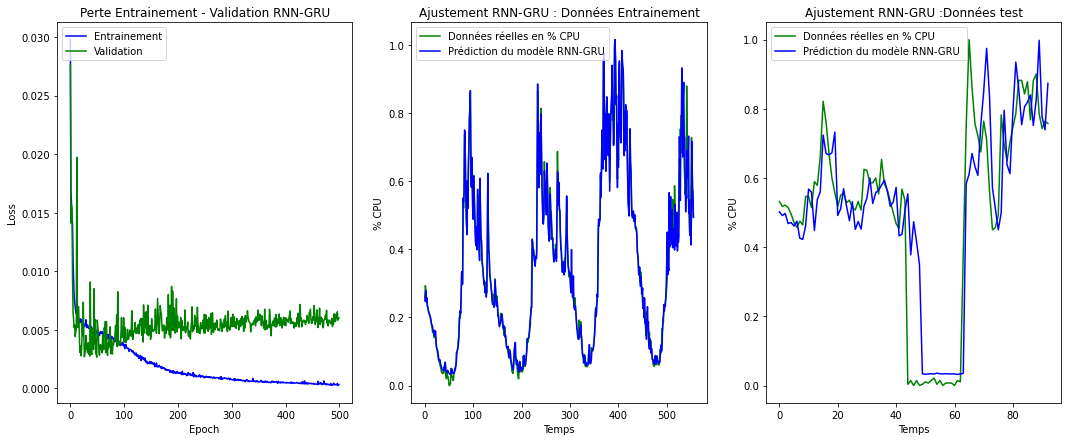

In [18]:
#  IV.2.3 - : Calcul des erreurs & Plot training & validation accuracy values

ErreurPrediction("Erreur données Entrainement",y_train,modelGRU.predict(x_train))
ErreurPrediction("Erreur données test",y_test,modelGRU.predict(x_test))

LossAccuracy("enrainement",modelGRU,x_train,y_train)
LossAccuracy("Test", modelLSTM,x_test,y_test)
Affichage(historygru,modelGRU,"RNN-GRU")

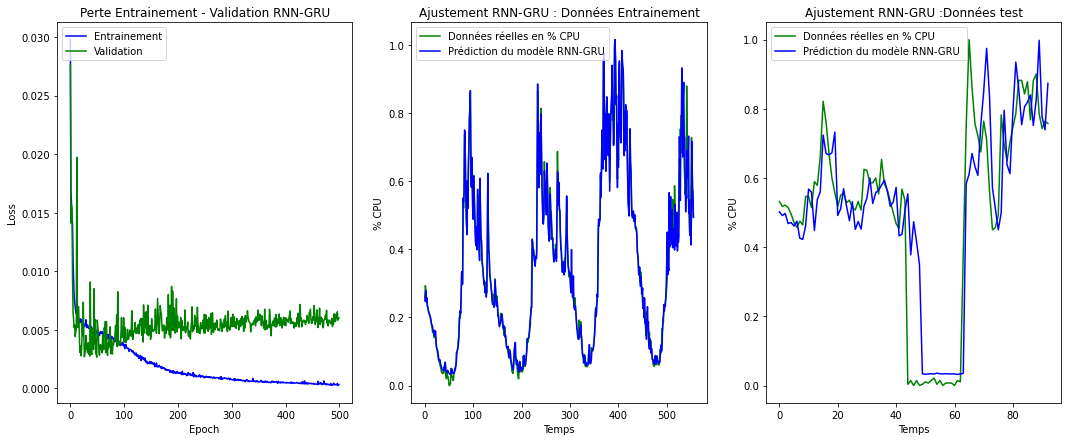

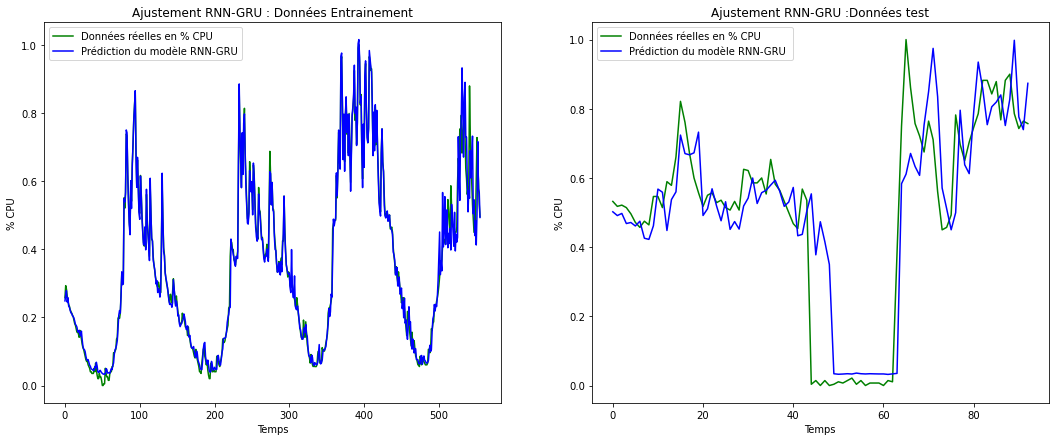

In [19]:
Affichage(historygru,modelGRU,"RNN-GRU")

Affichage_Model(modelGRU,"RNN-GRU")

In [20]:
# IV.3 - : Entrainement du model RNN bidirectionnel

#IV.3.1 - : Initialising AND TRAINING the RNN bidirectionnel


start=time()
modelbidir = Sequential()
modelbidir.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1],1))))
modelbidir.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
modelbidir.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
modelbidir.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
modelbidir.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
modelbidir.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
modelbidir.add(Bidirectional(LSTM(units = 100)))
modelbidir.add(Dense(units = 1))
modelbidir.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])

historybidir=modelbidir.fit(x_train, y_train, epochs = 500, batch_size = 5,
                       validation_split=0.20,verbose=1 )

elapsed=time()-start
print(modelbidir.summary())
print('duree totale est de :',elapsed/60)
# 38 minutes



Train on 444 samples, validate on 112 samples
Epoch 1/500
444/444 [==============================] - 33s 73ms/sample - loss: 0.0437 - accuracy: 0.0068 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 2/500
444/444 [==============================] - 4s 10ms/sample - loss: 0.0163 - accuracy: 0.0068 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 3/500
444/444 [==============================] - 4s 10ms/sample - loss: 0.0113 - accuracy: 0.0068 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 4/500
444/444 [==============================] - 4s 10ms/sample - loss: 0.0115 - accuracy: 0.0068 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 5/500
444/444 [==============================] - 4s 10ms/sample - loss: 0.0099 - accuracy: 0.0068 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 6/500
444/444 [==============================] - 4s 10ms/sample - loss: 0.0100 - accuracy: 0.0068 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 7/500
444/444 [==============================] 

In [21]:
# IV.3.2 - :  Enregistrement et importation  du model

modelbidir.save('modelRnnBidirectionalProj.h5') 
#creates a HDF5 file 'my_model.h5' et model = load_model('modelRnnLSTMProjetSecurite.h5')
# pour le detruire del model  # deletes the existing model
modelbidir = load_model('modelRnnBidirectionalProj.h5')


La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9753110785761017
La MAE modèle Erreur données Entrainement est de: 0.020384819118171926 
La MSE modèle Erreur données Entrainement est de: 0.001531811972717548 
RMSE est:0.0391383695715285
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.843351239468254
La MAE modèle Erreur données test est de: 0.07052815254840615 
La MSE modèle Erreur données test est de: 0.012180739357655077 
RMSE est:0.11036638690133457
Les pertes sur les données enrainement sont: 
loss: 0.15%
accuracy: 0.54%
Les pertes sur les données Test sont: 
loss: 1.22%
accuracy: 5.38%


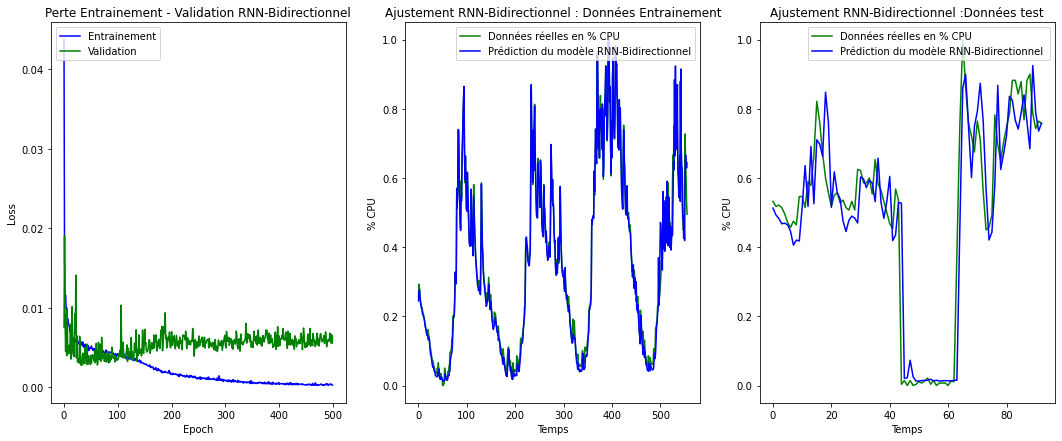

In [22]:
# IV.3.3 - : Calcul des erreurs & Plot training & validation loss values

ErreurPrediction("Erreur données Entrainement",y_train,modelbidir.predict(x_train))
ErreurPrediction("Erreur données test",y_test,modelbidir.predict(x_test))

LossAccuracy("enrainement",modelbidir,x_train,y_train)
LossAccuracy("Test", modelbidir,x_test,y_test)
Affichage(historybidir,modelbidir,"RNN-Bidirectionnel")

In [26]:

# IV.4 - : Entrainement du modèle ConvNet1D

#IV.4.1 - : Initialising and training the ConvNet1D # forme (samples,time,features)

start=time()
modelConvNet1D = Sequential()
modelConvNet1D.add(Conv1D(100, kernel_size=1,activation='tanh',input_shape=(x_train.shape[1], 1)))
modelConvNet1D.add(Conv1D(128, kernel_size=1,activation='tanh'))
modelConvNet1D.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
modelConvNet1D.add(Conv1D(64, kernel_size=1,activation='tanh'))
modelConvNet1D.add(Conv1D(32, kernel_size=1,activation='tanh'))
modelConvNet1D.add(Conv1D(64, kernel_size=1,activation='tanh'))
modelConvNet1D.add(Conv1D(128, kernel_size=1,activation='tanh'))
modelConvNet1D.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
modelConvNet1D.add(GlobalMaxPooling1D())
#modelConvNet1D.add(Flatten()) # pas besoin si globalMaxPooling1D est deja là
modelConvNet1D.add(Dense(128,activation='tanh'))
modelConvNet1D.add(Dense(100,activation='tanh'))
modelConvNet1D.add(Dense(1))
modelConvNet1D.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])

historyConvNet1D=modelConvNet1D.fit(x_train, y_train, epochs = 500, batch_size = 5,
                           validation_split=0.20,verbose=1)

elapsed=time()-start
print(modelConvNet1D.summary())
print('duree totale est de :',elapsed/60)
# 3 minutes



Train on 444 samples, validate on 112 samples
Epoch 1/500
444/444 [==============================] - 2s 4ms/sample - loss: 0.0306 - accuracy: 0.0045 - val_loss: 0.0099 - val_accuracy: 0.0000e+00
Epoch 2/500
444/444 [==============================] - 0s 868us/sample - loss: 0.0151 - accuracy: 0.0068 - val_loss: 0.0143 - val_accuracy: 0.0000e+00
Epoch 3/500
444/444 [==============================] - 0s 868us/sample - loss: 0.0135 - accuracy: 0.0068 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 4/500
444/444 [==============================] - 0s 868us/sample - loss: 0.0106 - accuracy: 0.0068 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 5/500
444/444 [==============================] - 0s 833us/sample - loss: 0.0090 - accuracy: 0.0068 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 6/500
444/444 [==============================] - 0s 889us/sample - loss: 0.0080 - accuracy: 0.0068 - val_loss: 0.0095 - val_accuracy: 0.0000e+00
Epoch 7/500
444/444 [=============================

La R^2-Squared(r2_score) du modèle Erreur données Entrainement est : 0.9302875905904628
La MAE modèle Erreur données Entrainement est de: 0.0476648254943614 
La MSE modèle Erreur données Entrainement est de: 0.004325272114850261 
RMSE est:0.06576680100818544
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.6998475191759373
La MAE modèle Erreur données test est de: 0.08864982867707856 
La MSE modèle Erreur données test est de: 0.02333934289719796 
RMSE est:0.1527721928139999
Les pertes sur les données enrainement sont: 
loss: 0.43%
accuracy: 0.54%
Les pertes sur les données Test sont: 
loss: 2.33%
accuracy: 4.30%


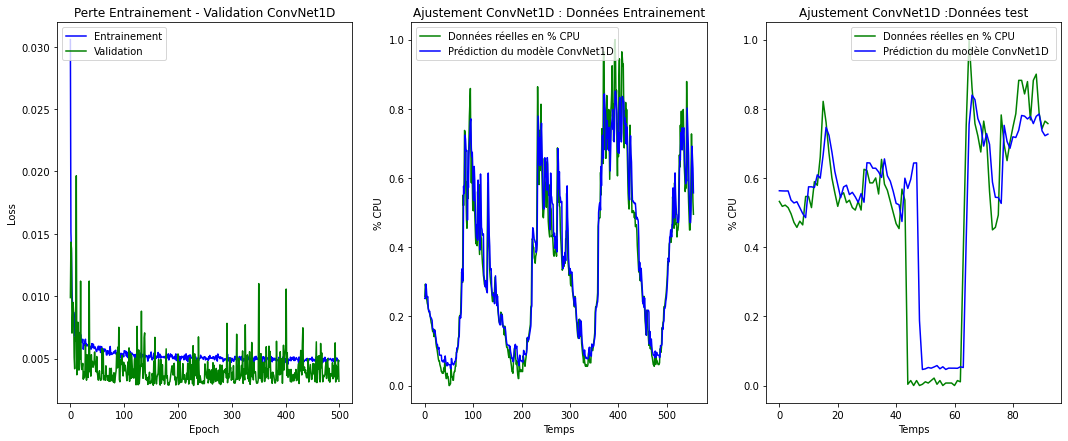

In [27]:
# IV.4.2 - :  Enregistrement et importation  du model

modelConvNet1D.save('modelConvNet1DProj.h5') 
#creates a HDF5 file 'my_model.h5' et model = load_model('modelRnnLSTMProjetSecurite.h5')
# pour le detruire del model  # deletes the existing model
modelConvNet1D = load_model('modelConvNet1DProj.h5')

# IV.4.3 - : Calcul des erreurs & Plot training & validation loss values

ErreurPrediction("Erreur données Entrainement",y_train,modelConvNet1D.predict(x_train))
ErreurPrediction("Erreur données test",y_test,modelConvNet1D.predict(x_test))

LossAccuracy("enrainement",modelConvNet1D,x_train,y_train)
LossAccuracy("Test", modelConvNet1D,x_test,y_test)
Affichage(historyConvNet1D,modelConvNet1D,"ConvNet1D")
